In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

'''
FinanceTracker is a class that tracks your finances. It has three dataframes:

  - log: A dataframe that tracks the balance of your account on a given day. 
         It is generated using the following two dataframes

  - recurring: A dataframe that tracks recurring cashflows. Denote reccuring
               cashflows using the addRecurring() function

  - single: A dataframe that tracks one-time transactions. Denote single 
            cashflows using the addSingle() function

The data in this class can be saved and loaded through csv files. Data can be 
viewed through the display() and plot() functions, or through Excel. Data is
intended to be entered through the addRecurring() and addSingle() functions, but
can also be entered through the csv files. Modification in the log dataframe
will be overwritten every time the data is displayed. A template for entering 
data is provided in the following cell.
'''
class FinanceTracker:
  def __init__(self, name='FinanaceTracker1', startingBalance = 0, starting_date='0000-01-01', ending_date='9999-01-01'):
    self.name = name
    self.starting_date = pd.to_datetime(starting_date)
    self.ending_date = pd.to_datetime(ending_date)
    self.startingBalance = startingBalance
    self.log = pd.DataFrame(columns=['Date', 'Amount', 'Change'])
    self.recurring = pd.DataFrame(columns=['Source', 'StartingDate', 'EndingDate', 'Amount', 'FrequencyInDays'])
    self.single = pd.DataFrame(columns=['Source', 'Date', 'Amount'])
    self.recompute = False

    # Adds the starting balance
    self.addSingle('Starting Balance', self.starting_date, self.startingBalance)

  # Display the log
  def display(self):
    self.compute()
    print(self.log)

  # Plot the log
  def plot(self):
    self.compute()
    _, ax = plt.subplots(figsize=(20,10))
    ax.plot(self.log.Date, self.log.Amount, color='black', label='Balance')
    ax.plot(self.log.Date, self.log.Change, color='red', label='Change in Balance')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.yaxis.set_major_locator(plt.MaxNLocator(25)) # type: ignore
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_xlabel('Date')
    ax.set_ylabel('Amount')
    ax.set_title('Balance: ' + self.name)
    plt.xticks(rotation=45)
    plt.grid()
    ax.legend()
    plt.show()

  # Returns the number of days between the starting and ending date
  def dayDifference(self, a = None, b = None):
    if a is None or b is None:
      return abs((self.ending_date - self.starting_date).days)
    else:
      return abs((pd.to_datetime(b) - pd.to_datetime(a)).days)

  # Populates the log in O(n+m) time where n is the number of days, and m is the number of transactions
  def compute(self):
    if not self.recompute: return
    # Reset and prepopulate the log with 0s
    self.log = pd.DataFrame(columns=['Date', 'Amount', 'Change'])
    for i in range(self.dayDifference()):
      self.log.loc[len(self.log)] = [self.starting_date + pd.DateOffset(days=i), 0, 0] # type: ignore

    # Sets the amount on a given date to the sum of all transactions that occur on that date (or the change in balance)
    for elem in self.single.itertuples():
      self.setAmount(pd.to_datetime(elem.Date), elem.Amount)
    
    # Does the same for recurring transactions
    for elem in self.recurring.itertuples():
      current_date = pd.to_datetime(elem.StartingDate)
      while(current_date <= pd.to_datetime(elem.EndingDate) and current_date <= self.ending_date):
        self.setAmount(current_date, elem.Amount)
        current_date += pd.DateOffset(days=elem.FrequencyInDays)

    # Sets the current day's balance to the previous day's balance plus the change in balance. This is more
    # efficient applying transactions to the log one by one, since it would be O(n*m) time
    current_balance = 0
    for i in range(self.dayDifference()):
      current_balance += self.log.iloc[i].Change
      try:
        self.log.at[i,"Amount"] = current_balance
      except:
        _ = 0
        
    self.recompute = False

  # Sets a value to a date, indexing the pandas dataframe
  def setAmount(self, date, value):
    self.recompute = True
    index = abs((self.starting_date - date).days)
    try:
      self.log.at[index,"Change"] += value
    except:
      _ = 0

  # Adds a recurring cashflow
  def addRecurring(self, source, starting_date, ending_date, amount, frequency_in_days):
    self.recompute = True
    self.recurring.loc[len(self.recurring)] = [source, starting_date, ending_date, amount, frequency_in_days] # type: ignore

  # Adds a single cashflow
  def addSingle(self, source, date, amount):
    if pd.to_datetime(date) < self.starting_date or pd.to_datetime(date) > self.ending_date: return
    self.recompute = True
    self.single.loc[len(self.single)] = [source, date, amount] # type: ignore

  # Saves the data to csv files
  def saveData(self):
    self.compute()
    self.log.to_csv(self.name + 'Log.csv', index=False)
    self.recurring.to_csv(self.name + 'Recurring.csv', index=False)
    self.single.to_csv(self.name + 'Single.csv', index=False)

  # Loads the data from csv files
  def loadData(self):
    self.recompute = True
    self.log = pd.read_csv(self.name + 'Log.csv')
    self.recurring = pd.read_csv(self.name + 'Recurring.csv')
    self.single = pd.read_csv(self.name + 'Single.csv')


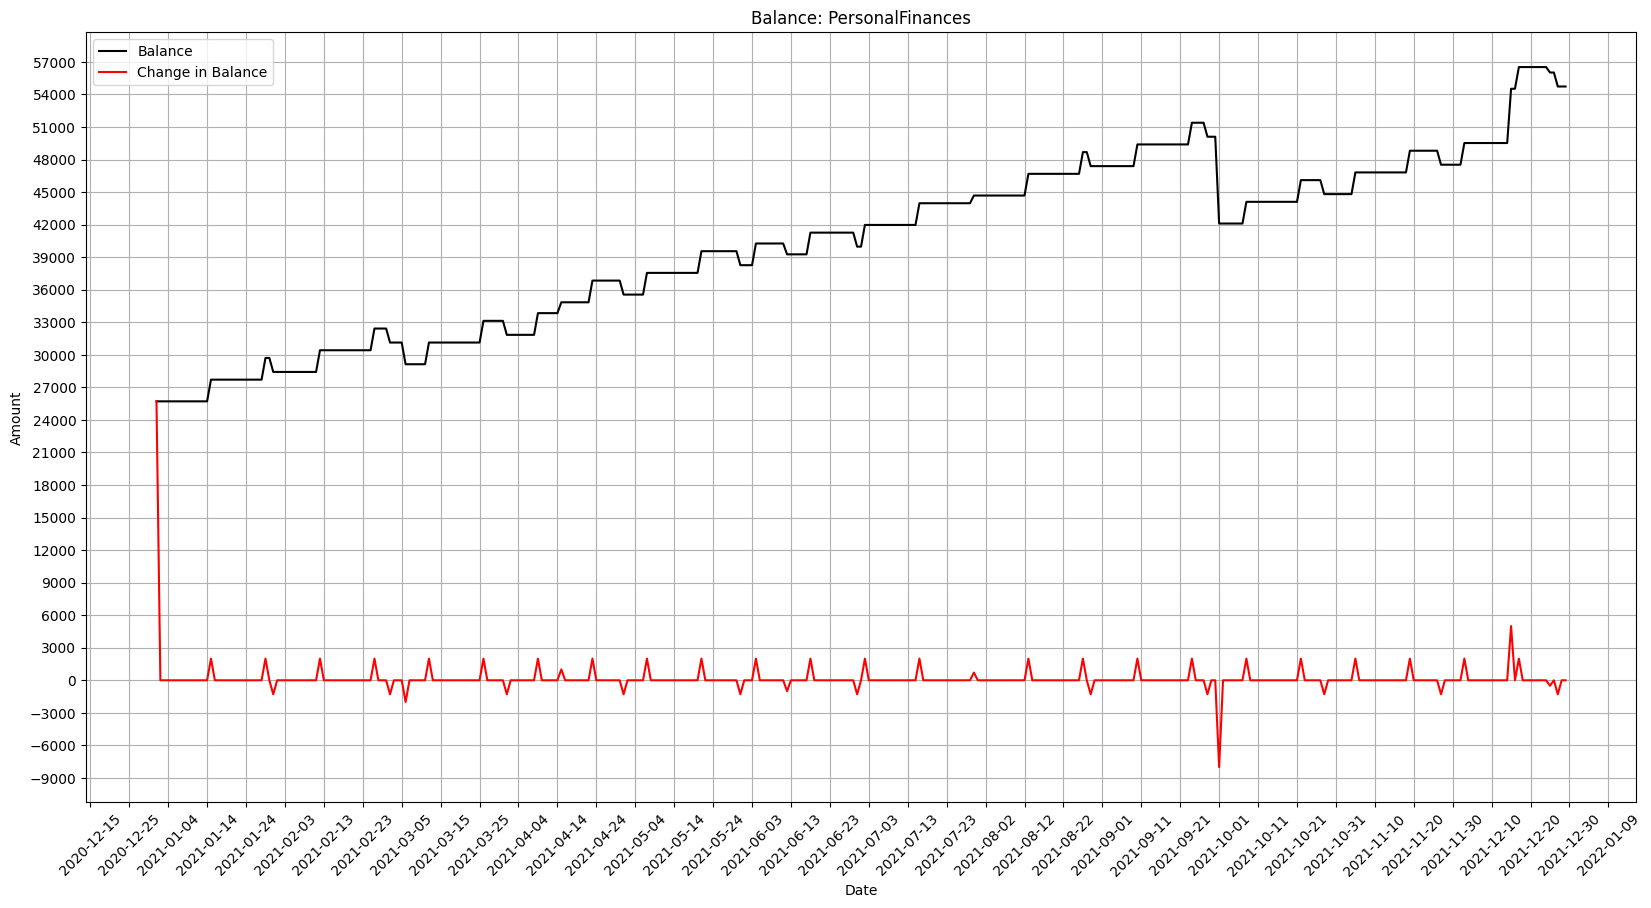

In [2]:
# An example usecase

# FINANCETRACKER INSTANTIATION
#                                        Init balance               End date
tracker = FinanceTracker('PersonalFinances', 25000, '2021-01-01', '2021-12-30')
#                              Title                 Start Date

# RECURRING CASHFLOW
#                    Title                   End date       Frequency
tracker.addRecurring('Rent', '2021-01-01', '2021-12-31', -800, 30)
#                             Start date               Cashflow

# Expenses
tracker.addRecurring('Car Payments', '2021-01-01', '2021-12-31', -370, 30)
tracker.addRecurring('Car Insurance', '2021-01-01', '2021-12-31', -50, 30)
tracker.addRecurring('Phone', '2021-01-01', '2021-12-31', -50, 30)
tracker.addRecurring('Internet', '2021-01-01', '2021-12-31', -50, 30)
tracker.addRecurring('Spotify', '2021-01-01', '2021-12-31', -10, 30)
tracker.addRecurring('Netflix', '2021-01-01', '2021-12-31', -10, 30)
tracker.addRecurring('Groceries', '2021-01-01', '2021-12-31', -150, 30)
tracker.addRecurring('Utilities', '2021-01-01', '2021-12-31', -100, 30)
tracker.addRecurring('Miscellaneous', '2021-01-01', '2021-12-31', -100, 30)

# Income
tracker.addRecurring('Job', '2021-01-01', '2021-12-31', 2000, 14)
tracker.addRecurring('Stocks', '2021-01-01', '2021-12-31', 100, 30)
tracker.addRecurring('Side Hustle', '2021-01-01', '2021-12-31', 300, 30)

# SINGLE CASHFLOW
#                      Title                    Cashflow
tracker.addSingle('Phone Upgrade', '2021-06-12', -1000)
#                                     Date

# Expenses
tracker.addSingle('Car Repair', '2021-03-06', -2000)
tracker.addSingle('Gift', '2021-12-25', -500)
tracker.addSingle('Vacation', '2021-10-01', -8000)

# Income
tracker.addSingle('Tax Return', '2021-04-15', 1000)
tracker.addSingle('Bonus', '2021-12-15', 5000)

# Saves data to .csv files
tracker.saveData()

# Plots data
tracker.plot()